<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/CycleGAN_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-krny9ku6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-krny9ku6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=b160f7fb298403825d053300bf205cc52b8ca603d513bd4e320e5ce330643c97
  Stored in directory: /tmp/pip-ephem-wheel-cache-7430brcj/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


### DISCRIMINATOR

In [ ]:
from numpy.random import randint

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

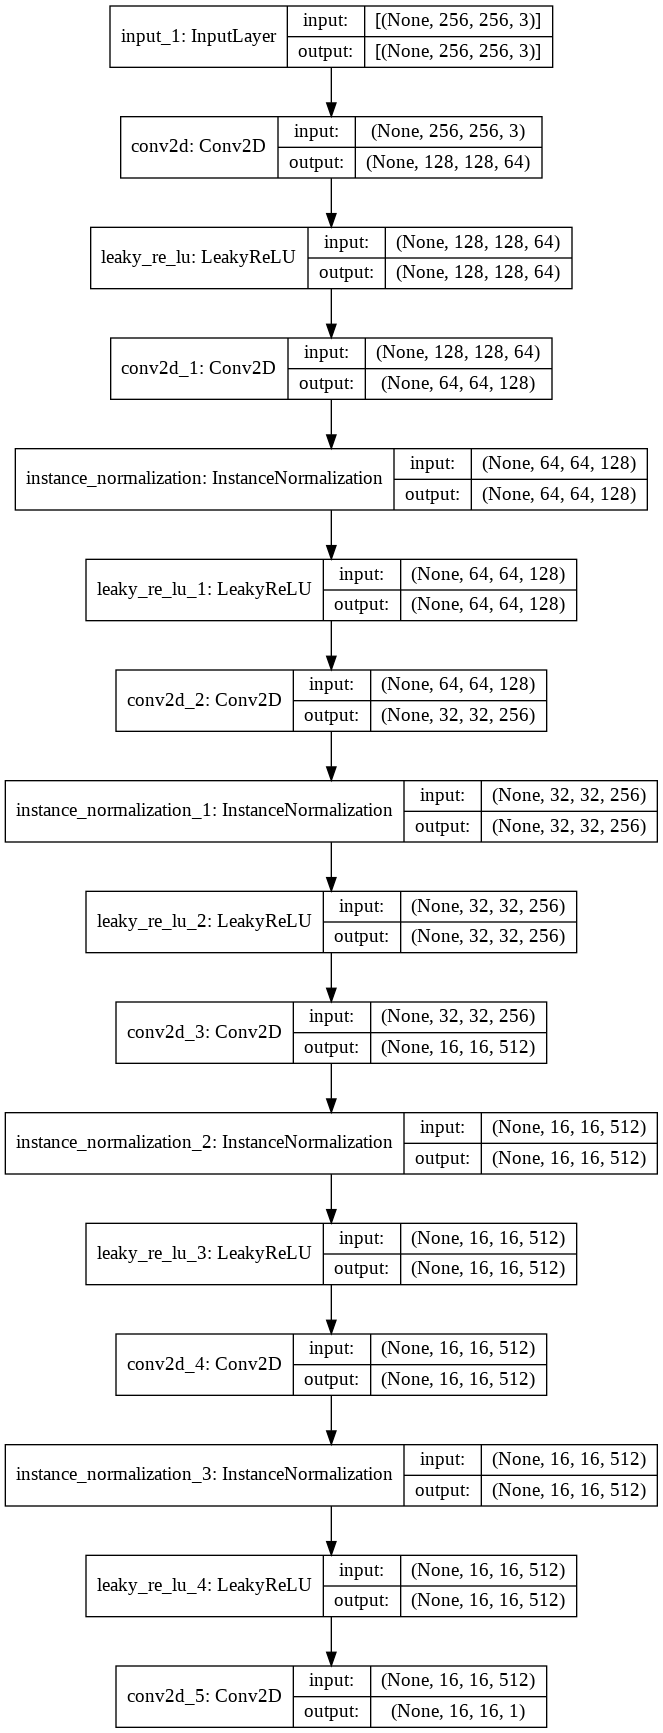

In [ ]:
# example of defining a 70x70 patchgan discriminator model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model
 
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model
 
# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

### GENERATOR using RESNET

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator(image_shape=(256,256,3), n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

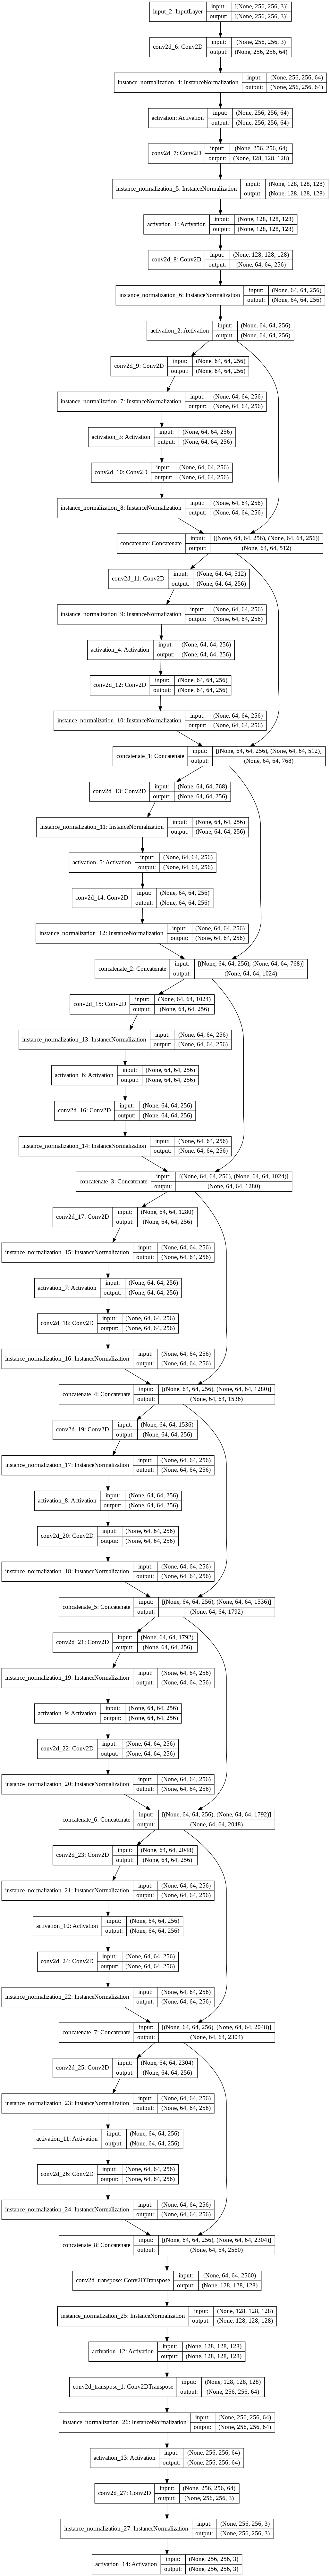

In [ ]:
# example of an encoder-decoder generator for the cyclegan
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

# Create the model
model = define_generator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

Implement Composite Models for Least Squares and Cycle Loss

In [ ]:
# define a composite model for updating generators by adverarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
  # ensure the model we're updating is trainable
  g_model_1.trainable = True
  # mark discriminator as not trainable
  d_model.trainable = False
  # mark other generator model as not trainable
  g_model_2.trainable = False
  # discriminator element
  input_gen = Input(shape = image_shape)
  gen1_out = g_model_1(input_gen)
  output_d = d_model(gen1_out)
  # identity element
  input_id = Input(shape=image_shape)
  output_id = g_model_1(input_id)
  # forward cycle
  output_f = g_model_2(gen1_out)
  # backward cycle
  gen2_out = g_model_2(input_id)
  output_b = g_model_1(gen2_out)
  # define model graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
  # define optimization algorithm configuration
  opt = Adam(lr=0.0002, beta_1 = 0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
  return model


In [ ]:
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Update Discriminator and Generator Models

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y



In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))


In [ ]:
# load image data
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1261, 256, 256, 3) (1267, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


AttributeError: ignored

# Prepare Dataset

In [ ]:
#@title
%%bash

FILE=apple2orange

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir datasets
mkdir -p images/apple2orange/
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

In [ ]:
mkdir -p images/apple2orange/

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, color_mode='grayscale', target_size=size)
		#pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)
 
# dataset path
#path = 'datasets/apple2orange/'
path = 'drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/Acc2PPG/'
# load dataset A
# dataA1 = load_images(path + 'trainA/')
# dataAB = load_images(path + 'testA/')
# dataA = vstack((dataA1, dataAB))
dataA = load_images(path + 'NoisePPG/')
print('Loaded dataA: ', dataA.shape)
# load dataset B
# dataB1 = load_images(path + 'trainB/')
# dataB2 = load_images(path + 'testB/')
# dataB = vstack((dataB1, dataB2))
dataB = load_images(path + 'CleanPPG/')
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
#filename = 'acc2ppg_gray256.npz'
#filename = 'acc2ppg_256.npz'
#savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

In [ ]:
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Saved dataset:  acc2ppg_gray256.npz


## Copy files to the drive

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

In [ ]:
cp 'g_model_AtoB_000004.h5' './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'

In [ ]:
cp 'g_model_BtoA_000004.h5' './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'

In [ ]:
cp 'd_model_A_000004.h5' './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'

In [ ]:
cp 'd_model_B_000004.h5' './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'

In [ ]:
cp 'acc2ppg_gray256.npz' './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/'

In [ ]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/acc2ppg_256.npz' '/content'

In [ ]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/g_model_AtoB_001319.h5' '/content'

In [1]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/acc2ppg_gray256.npz' '/content'

In [2]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/d_model_B_000002_unet.h5' '/content'

In [3]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/d_model_A_000002_unet.h5' '/content'

In [4]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/g_model_AtoB_000002_unet.h5' '/content'

In [5]:
cp './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/g_model_BtoA_000002_unet.h5' '/content'

In [ ]:
ls './drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/'

acc2ppg_256.npz         g_model_AtoB_001319.h5  saved_models/
acc2ppg_gray256.npz     g_model_BtoA_000630.h5
g_model_AtoB_000630.h5  Models/


Loaded:  (2638, 256, 256, 1) (528, 256, 256, 1)


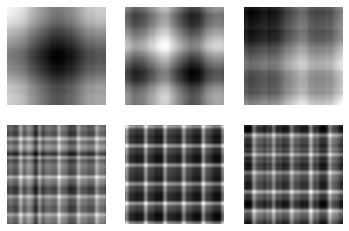

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
import numpy as np

# load the dataset
#data = load('apple2orange_256.npz')
#dataA, dataB = data['arr_0'], data['arr_1']
#data = load('acc2ppg_256.npz')
data = load('acc2ppg_gray256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i][:,:,0], cmap='gray')	
	#pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i][:,:,0], cmap='gray')
	#pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

(256, 256, 1)


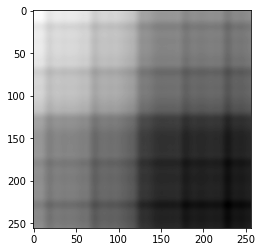

In [ ]:
print(np.shape(dataA[211]))
pyplot.gray()
#plt.imshow(images_arr[:,:,0], cmap='gray')
pyplot.imshow(dataA[211][:,:,0], cmap='gray')

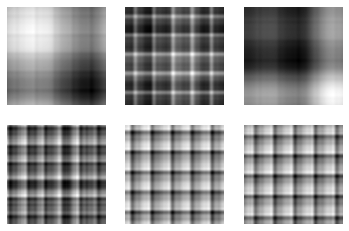

In [ ]:
n_samples = 3
random_list0 = [np.random.randint(np.shape(dataA)[0]) for i in  range(n_samples)]
random_list1 = [np.random.randint(np.shape(dataB)[0]) for i in  range(n_samples)]
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	#pyplot.imshow(dataA[random_list0[i]].astype('uint8'))
	pyplot.imshow(dataA[random_list0[i]][:,:,0], cmap='gray')
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	#pyplot.imshow(dataB[random_list1[i]].astype('uint8'))
	pyplot.imshow(dataB[random_list1[i]][:,:,0], cmap='gray') 
pyplot.show()

In [ ]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

### Full Code

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('&gt;Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B-&gt;A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -&gt; [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A-&gt;B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -&gt; [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A-&gt;B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B-&gt;A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

# load image data
#dataset = load_real_samples('acc2ppg_gray256.npz')
dataset = load_real_samples('acc2ppg_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -&gt; B
g_model_AtoB = define_generator(image_shape)
# generator: B -&gt; A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -&gt; [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -&gt; [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -&gt; B -&gt; [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -&gt; A -&gt; [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

##Install tensorflow_addon

In [6]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


###  FOR SHAPE (256, 256, 3)

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
import tensorflow_addons as tfa
#from tensorflow_addons.layers.instancenormalization import InstanceNormalization
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('&gt;Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 2
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B-&gt;A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -&gt; [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A-&gt;B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -&gt; [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)
			#save_models(i, d_model_A, d_model_B)

### FOR SHAPE (256, 256, 1)

In [ ]:
s = 'a ' + 'b' + 'c'
print(s)

a bc


In [16]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
import tensorflow_addons as tfa
#from tensorflow_addons.layers.instancenormalization import InstanceNormalization
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g
def upsample(input_layer, skip_input, n_filters, f_size=4, dropout_rate=0):
	u = UpSampling2D(size=2)(input_layer)
	u = Conv2D(n_filters, kernel_size=f_size,strides=1, padding='same')(u)
	u = tfa.layers.InstanceNormalization(axis = -1, center = False, scale = False)(u)
	u = Activation('relu')(u)
	if dropout_rate:
		u = Dropout(dropout_rate)(u)
	
	u = Concatenate()([u, skip_input])
	return u
def downsample(input_layer, n_filters, f_size=4):
	d = Conv2D(n_filters, kernel_size=f_size, strides=2, padding='same')(input_layer)
	d = tfa.layers.InstanceNormalization(axis=-1, center = False, scale = False)(d)
	d = Activation('relu')(d)
	return d


# define the standalone generator model
# def define_generator(image_shape, n_resnet=9):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# image input
# 	in_image = Input(shape=image_shape)
# 	# c7s1-64
# 	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# d128
# 	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# d256
# 	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# R256
# 	for _ in range(n_resnet):
# 		g = resnet_block(256, g)
# 	# u128
# 	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# u64
# 	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	g = Activation('relu')(g)
# 	# c7s1-1
# 	g = Conv2D(1, (7,7), padding='same', kernel_initializer=init)(g)
# 	g = tfa.layers.InstanceNormalization(axis=-1)(g)
# 	out_image = Activation('tanh')(g)
# 	# define model
# 	model = Model(in_image, out_image)
# 	return model

# define the standalone generator model
def define_generator(image_shape):
	# weigth initialization
	init = RandomNormal(stddev=0.02)
	# image input
	img = Input(shape=image_shape)
	# DownSampling
	# self.gen_n_filters image_shape[0]
	n_filters = 32
	d1 = downsample(img, n_filters) # n_filters = size of image_shape
	d2 = downsample(d1, n_filters*2)
	d3 = downsample(d2, n_filters*4)
	d4 = downsample(d3, n_filters*8)
	
	# UpSampling
	u1 = upsample(d4, d3, n_filters*4)
	u2 = upsample(u1, d2, n_filters*2)
	u3 = upsample(u2, d1, n_filters)
 
	u4 = UpSampling2D(size=2)(u3)
 
	output = Conv2D(1, kernel_size= 4, strides=1, padding='same',kernel_initializer=init, activation='tanh')(u4) # number of channel is one
	model = Model(img, output)
	return model
 


# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d_unet.h5' % (step+1)
	g_model_AtoB.save(filename1)
	cmd = 'cp ' + filename1 + ' ./drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'
	os.system(cmd)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d_unet.h5' % (step+1)
	g_model_BtoA.save(filename2)
	cmd = 'cp ' + filename2 + ' ./drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'
	os.system(cmd) 
	print('&gt;Saved: %s and %s' % (filename1, filename2))
 
def save_models1(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'd_model_A_%06d_unet.h5' % (step+1)
	g_model_AtoB.save(filename1)
	cmd = 'cp ' + filename1 + ' ./drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'
	os.system(cmd) 
	# save the second generator model
	filename2 = 'd_model_B_%06d_unet.h5' % (step+1)
	g_model_BtoA.save(filename2)
	cmd = 'cp ' + filename2 + ' ./drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels/Models/'
	os.system(cmd) 
	print('&gt;Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i,:,:,0], cmap="gray")
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i,:,:,0], cmap="gray")
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)
times = 3
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 20, 16
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	#n_steps = 1200;
	
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B-&gt;A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -&gt; [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A-&gt;B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -&gt; [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:# n_steps
			# plot A->B translation
			summarize_performance(times, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(times, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:#bat_per_epo * 1
			# save the models
			save_models(times, g_model_AtoB, g_model_BtoA)
			save_models1(times, d_model_A, d_model_B)
	 	# Copy to Drive:
		


### Generate Model for the First time

In [8]:
from numpy import load
from matplotlib import pyplot
import numpy as np



# load image data
data = load('acc2ppg_gray256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
### Reshape the image (256,256,1)==>(256,256)==>(256,256,1)
# dataA = np.reshape(dataA,[-1, 256,256])
# dataA = np.reshape(dataA,[-1, 256,256,1])
# dataB = np.reshape(dataB,[-1, 256,256])
# dataB = np.reshape(dataB,[-1, 256,256,1])

dataA = (dataA - 127.5) / 127.5
dataB = (dataB - 127.5) / 127.5
dataset = [dataA, dataB]
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
#composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
#train models

Loaded:  (2638, 256, 256, 1) (528, 256, 256, 1)
Loaded (2638, 256, 256, 1) (528, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
d_model_A.summary()

In [ ]:
g_model_AtoB.summary()

### Load the model to resuse


# New Section

In [18]:
import tensorflow as tf
step = 1
filename1 = 'g_model_AtoB_%06d_unet.h5' % (step+1)
filename2 = 'g_model_BtoA_%06d_unet.h5' % (step+1)
filename3 = 'd_model_A_%06d_unet.h5' % (step+1)
filename4 = 'd_model_B_%06d_unet.h5' % (step+1)

g_model_AtoB = tf.keras.models.load_model(filename1)
g_model_BtoA = tf.keras.models.load_model(filename2)
d_model_A = tf.keras.models.load_model(filename3)
d_model_B = tf.keras.models.load_model(filename4)

In [11]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 5.9 MB/s 


In [ ]:
import visualkeras

visualkeras.layered_view(d_model_A, to_file='output.png')

In [19]:
# discriminator: A -> [real/fake]
#d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
#d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import shutil, os
import tensorflow as tf
step = 629
filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
files = [filename1, filename2]
for f in files:
    shutil.copy(f, 'drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/TrainModels')

In [ ]:
bat_per_epo = len(dataset[0])

In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.006,0.007] dB[0.009,0.045] g[2.147,2.504]
>2, dA[0.005,0.009] dB[0.009,0.014] g[2.573,2.831]
>3, dA[0.007,0.009] dB[0.007,0.016] g[2.338,2.563]
>4, dA[0.005,0.008] dB[0.009,0.017] g[2.345,2.564]
>5, dA[0.005,0.008] dB[0.008,0.021] g[2.233,2.601]
>6, dA[0.007,0.008] dB[0.008,0.026] g[1.945,2.356]
>7, dA[0.005,0.009] dB[0.007,0.026] g[2.190,2.311]
>8, dA[0.007,0.008] dB[0.009,0.026] g[2.138,2.627]
>9, dA[0.005,0.008] dB[0.010,0.014] g[2.073,2.194]
>10, dA[0.006,0.007] dB[0.011,0.030] g[1.927,2.475]
>11, dA[0.006,0.008] dB[0.008,0.028] g[2.155,2.607]
>12, dA[0.005,0.009] dB[0.008,0.032] g[2.126,2.509]
>13, dA[0.007,0.008] dB[0.008,0.030] g[2.138,2.553]
>14, dA[0.006,0.008] dB[0.008,0.025] g[2.402,3.120]
>15, dA[0.006,0.010] dB[0.009,0.020] g[2.134,2.679]
>16, dA[0.005,0.009] dB[0.010,0.043] g[2.064,2.720]
>17, dA[0.006,0.007] dB[0.009,0.038] g[2.152,2.876]
>18, dA[0.005,0.007] dB[0.008,0.029] g[1.850,2.220]
>19, dA[0.006,0.008] dB[0.009,0.028] g[2.045,2.431]
>20, dA[0.006,0.011] 

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>165, dA[0.006,0.015] dB[0.011,0.198] g[1.505,2.221]
>166, dA[0.005,0.011] dB[0.007,0.167] g[1.376,2.232]
>167, dA[0.006,0.009] dB[0.012,0.164] g[1.495,2.376]
>168, dA[0.006,0.016] dB[0.007,0.188] g[1.525,2.189]
>169, dA[0.009,0.010] dB[0.008,0.182] g[1.668,2.670]
>170, dA[0.007,0.022] dB[0.008,0.170] g[1.554,2.550]
>171, dA[0.007,0.016] dB[0.011,0.192] g[1.397,1.989]
>172, dA[0.008,0.009] dB[0.011,0.231] g[1.535,2.759]
>173, dA[0.005,0.008] dB[0.010,0.194] g[1.472,2.362]
>174, dA[0.006,0.011] dB[0.010,0.186] g[1.607,2.607]
>175, dA[0.006,0.021] dB[0.008,0.175] g[1.572,2.437]
>176, dA[0.006,0.016] dB[0.008,0.205] g[1.554,2.275]
>177, dA[0.006,0.009] dB[0.008,0.177] g[1.662,2.927]
>178, dA[0.006,0.013] dB[0.009,0.189] g[1.342,2.431]
>179, dA[0.007,0.008] dB[0.010,0.154] g[1.597,2.393]
>180, dA[0.006,0.017] dB[0.011,0.177] g[1.478,2.189]
>181, dA[0.005,0

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>329, dA[0.005,0.012] dB[0.010,0.261] g[1.357,2.141]
>330, dA[0.007,0.012] dB[0.008,0.280] g[1.522,2.610]
>331, dA[0.005,0.017] dB[0.008,0.253] g[1.517,2.136]
>332, dA[0.005,0.010] dB[0.009,0.272] g[1.394,2.469]
>333, dA[0.007,0.008] dB[0.009,0.237] g[1.370,2.275]
>334, dA[0.006,0.018] dB[0.009,0.266] g[1.317,2.000]
>335, dA[0.007,0.012] dB[0.009,0.246] g[1.664,2.418]
>336, dA[0.005,0.007] dB[0.008,0.300] g[1.296,2.332]
>337, dA[0.006,0.017] dB[0.009,0.283] g[1.156,1.874]
>338, dA[0.006,0.023] dB[0.010,0.225] g[1.452,1.864]
>339, dA[0.007,0.017] dB[0.011,0.210] g[1.696,2.685]
>340, dA[0.006,0.013] dB[0.008,0.261] g[1.505,2.503]
>341, dA[0.006,0.014] dB[0.008,0.277] g[1.334,2.273]
>342, dA[0.006,0.016] dB[0.010,0.258] g[1.548,2.605]
>343, dA[0.005,0.008] dB[0.009,0.305] g[1.274,2.166]
>344, dA[0.007,0.024] dB[0.008,0.230] g[1.382,2.061]
>345, dA[0.005,0

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>493, dA[0.006,0.037] dB[0.009,0.342] g[1.336,1.971]
>494, dA[0.006,0.018] dB[0.008,0.326] g[1.299,1.893]
>495, dA[0.006,0.008] dB[0.010,0.310] g[1.233,2.260]
>496, dA[0.005,0.047] dB[0.013,0.385] g[1.178,1.627]
>497, dA[0.007,0.013] dB[0.010,0.296] g[1.201,2.007]
>498, dA[0.006,0.019] dB[0.010,0.300] g[1.328,1.977]
>499, dA[0.006,0.013] dB[0.008,0.384] g[1.184,2.199]
>500, dA[0.006,0.044] dB[0.007,0.406] g[1.287,1.803]
>501, dA[0.007,0.033] dB[0.008,0.336] g[1.323,2.675]
>502, dA[0.007,0.008] dB[0.007,0.311] g[1.234,2.351]
>503, dA[0.007,0.018] dB[0.008,0.317] g[1.515,2.151]
>504, dA[0.005,0.012] dB[0.008,0.283] g[1.242,2.489]
>505, dA[0.006,0.018] dB[0.009,0.393] g[1.202,2.043]
>506, dA[0.006,0.037] dB[0.010,0.379] g[1.340,1.853]
>507, dA[0.006,0.009] dB[0.008,0.309] g[1.102,2.081]
>508, dA[0.006,0.022] dB[0.010,0.347] g[1.221,2.153]
>509, dA[0.006,0

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>657, dA[0.006,0.018] dB[0.007,0.355] g[1.182,1.940]
>658, dA[0.006,0.036] dB[0.011,0.307] g[1.156,1.755]
>659, dA[0.008,0.019] dB[0.008,0.396] g[1.085,1.821]
>660, dA[0.006,0.033] dB[0.007,0.402] g[1.252,1.805]
>661, dA[0.006,0.027] dB[0.009,0.399] g[1.131,2.145]
>662, dA[0.006,0.072] dB[0.011,0.380] g[1.232,1.591]
>663, dA[0.005,0.029] dB[0.011,0.380] g[1.272,2.258]
>664, dA[0.008,0.024] dB[0.009,0.325] g[1.258,2.067]
>665, dA[0.007,0.020] dB[0.011,0.343] g[1.159,1.924]
>666, dA[0.006,0.034] dB[0.008,0.386] g[1.211,1.806]
>667, dA[0.006,0.027] dB[0.007,0.342] g[1.172,2.083]
>668, dA[0.006,0.025] dB[0.008,0.411] g[1.011,1.737]
>669, dA[0.005,0.029] dB[0.008,0.374] g[1.159,1.637]
>670, dA[0.005,0.026] dB[0.007,0.417] g[1.018,2.038]
>671, dA[0.006,0.044] dB[0.007,0.383] g[1.028,1.550]
>672, dA[0.006,0.080] dB[0.007,0.320] g[1.315,1.779]
>673, dA[0.006,0

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>821, dA[0.007,0.082] dB[0.008,0.334] g[1.199,1.533]
>822, dA[0.006,0.043] dB[0.008,0.376] g[1.230,1.810]
>823, dA[0.005,0.086] dB[0.009,0.337] g[1.243,1.675]
>824, dA[0.006,0.051] dB[0.010,0.424] g[1.109,1.945]
>825, dA[0.006,0.083] dB[0.007,0.346] g[1.012,1.500]
>826, dA[0.006,0.027] dB[0.010,0.390] g[1.193,1.863]
>827, dA[0.006,0.042] dB[0.008,0.405] g[1.133,1.788]
>828, dA[0.007,0.048] dB[0.008,0.392] g[1.336,2.081]
>829, dA[0.006,0.106] dB[0.008,0.358] g[1.102,1.532]
>830, dA[0.005,0.046] dB[0.009,0.365] g[0.988,1.683]
>831, dA[0.008,0.070] dB[0.009,0.329] g[1.069,1.451]
>832, dA[0.006,0.034] dB[0.011,0.323] g[1.139,1.828]
>833, dA[0.005,0.042] dB[0.009,0.362] g[1.224,1.883]
>834, dA[0.005,0.049] dB[0.006,0.324] g[1.116,1.655]
>835, dA[0.008,0.034] dB[0.010,0.354] g[1.178,1.886]
>836, dA[0.006,0.045] dB[0.007,0.358] g[1.044,1.626]
>837, dA[0.006,0

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>985, dA[0.006,0.084] dB[0.010,0.356] g[1.068,1.607]
>986, dA[0.007,0.058] dB[0.007,0.394] g[1.186,2.059]
>987, dA[0.006,0.144] dB[0.007,0.405] g[1.064,1.452]
>988, dA[0.005,0.096] dB[0.010,0.405] g[1.026,1.383]
>989, dA[0.005,0.093] dB[0.010,0.428] g[1.041,1.445]
>990, dA[0.006,0.087] dB[0.011,0.398] g[1.159,1.754]
>991, dA[0.006,0.075] dB[0.007,0.358] g[0.978,1.574]
>992, dA[0.006,0.116] dB[0.011,0.362] g[1.133,1.535]
>993, dA[0.005,0.100] dB[0.006,0.329] g[1.064,1.315]
>994, dA[0.007,0.079] dB[0.008,0.414] g[1.012,1.547]
>995, dA[0.006,0.105] dB[0.009,0.448] g[1.023,1.420]
>996, dA[0.006,0.093] dB[0.009,0.369] g[1.090,1.544]
>997, dA[0.008,0.069] dB[0.010,0.386] g[1.039,1.474]
>998, dA[0.006,0.083] dB[0.008,0.445] g[0.912,1.469]
>999, dA[0.005,0.050] dB[0.007,0.424] g[1.051,1.613]
>1000, dA[0.006,0.075] dB[0.010,0.394] g[1.046,1.676]
>1001, dA[0.006

&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1149, dA[0.006,0.185] dB[0.010,0.397] g[1.053,1.286]
>1150, dA[0.006,0.180] dB[0.011,0.450] g[0.929,1.123]
>1151, dA[0.007,0.215] dB[0.009,0.365] g[0.935,1.098]
>1152, dA[0.007,0.160] dB[0.011,0.382] g[0.961,1.283]
>1153, dA[0.005,0.140] dB[0.010,0.426] g[0.993,1.372]
>1154, dA[0.005,0.173] dB[0.010,0.374] g[1.155,1.468]
>1155, dA[0.006,0.186] dB[0.009,0.416] g[0.998,1.153]
>1156, dA[0.006,0.196] dB[0.007,0.413] g[0.855,1.069]
>1157, dA[0.007,0.186] dB[0.010,0.400] g[0.913,1.125]
>1158, dA[0.007,0.181] dB[0.009,0.425] g[0.896,1.224]
>1159, dA[0.007,0.159] dB[0.011,0.434] g[1.012,1.180]
>1160, dA[0.006,0.164] dB[0.010,0.413] g[1.025,1.411]
>1161, dA[0.006,0.176] dB[0.009,0.414] g[1.050,1.290]
>1162, dA[0.006,0.172] dB[0.008,0.402] g[1.017,1.313]
>1163, dA[0.007,0.138] dB[0.011,0.426] g[0.930,1.205]
>1164, dA[0.006,0.198] dB[0.008,0.405] g[1.020,1.436]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1313, dA[0.006,0.184] dB[0.009,0.387] g[1.217,1.563]
>1314, dA[0.006,0.248] dB[0.008,0.378] g[1.061,1.361]
>1315, dA[0.006,0.166] dB[0.009,0.375] g[1.081,1.469]
>1316, dA[0.007,0.259] dB[0.007,0.414] g[0.981,1.237]
>1317, dA[0.006,0.193] dB[0.010,0.409] g[1.026,1.282]
>1318, dA[0.008,0.211] dB[0.008,0.378] g[1.002,1.229]
>1319, dA[0.006,0.223] dB[0.011,0.360] g[1.022,1.261]
>1320, dA[0.007,0.184] dB[0.008,0.436] g[0.972,1.220]
>1321, dA[0.006,0.182] dB[0.010,0.383] g[0.898,1.248]
>1322, dA[0.005,0.201] dB[0.008,0.423] g[0.985,1.430]
>1323, dA[0.007,0.201] dB[0.010,0.411] g[0.867,1.066]
>1324, dA[0.007,0.263] dB[0.007,0.413] g[0.850,1.009]
>1325, dA[0.006,0.234] dB[0.010,0.466] g[0.905,1.025]
>1326, dA[0.007,0.273] dB[0.013,0.441] g[0.970,1.055]
>1327, dA[0.007,0.244] dB[0.011,0.459] g[1.051,1.235]
>1328, dA[0.005,0.148] dB[0.008,0.431] g[0.883,1.290]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1477, dA[0.007,0.321] dB[0.011,0.385] g[0.962,1.195]
>1478, dA[0.007,0.279] dB[0.012,0.371] g[0.976,1.139]
>1479, dA[0.007,0.290] dB[0.011,0.442] g[1.070,1.323]
>1480, dA[0.005,0.272] dB[0.010,0.406] g[1.184,1.523]
>1481, dA[0.006,0.352] dB[0.010,0.389] g[0.897,1.131]
>1482, dA[0.007,0.353] dB[0.008,0.441] g[0.920,1.141]
>1483, dA[0.007,0.265] dB[0.009,0.400] g[1.054,1.278]
>1484, dA[0.006,0.294] dB[0.009,0.416] g[0.933,1.097]
>1485, dA[0.007,0.277] dB[0.007,0.424] g[0.811,0.977]
>1486, dA[0.006,0.318] dB[0.009,0.436] g[0.878,1.011]
>1487, dA[0.006,0.318] dB[0.013,0.413] g[0.916,1.054]
>1488, dA[0.006,0.345] dB[0.008,0.427] g[0.801,0.955]
>1489, dA[0.007,0.377] dB[0.009,0.426] g[0.876,0.863]
>1490, dA[0.006,0.350] dB[0.010,0.418] g[0.984,1.156]
>1491, dA[0.009,0.331] dB[0.010,0.416] g[0.951,1.069]
>1492, dA[0.008,0.365] dB[0.009,0.407] g[0.841,1.000]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1641, dA[0.006,0.321] dB[0.008,0.458] g[0.842,1.019]
>1642, dA[0.006,0.390] dB[0.007,0.423] g[0.792,0.926]
>1643, dA[0.007,0.382] dB[0.007,0.444] g[0.842,0.961]
>1644, dA[0.005,0.355] dB[0.010,0.433] g[0.974,1.055]
>1645, dA[0.006,0.308] dB[0.008,0.454] g[0.766,0.979]
>1646, dA[0.006,0.306] dB[0.010,0.467] g[0.811,1.036]
>1647, dA[0.006,0.352] dB[0.007,0.442] g[0.873,1.275]
>1648, dA[0.005,0.333] dB[0.008,0.459] g[0.830,1.014]
>1649, dA[0.006,0.381] dB[0.007,0.433] g[0.803,0.936]
>1650, dA[0.006,0.310] dB[0.009,0.455] g[0.852,1.004]
>1651, dA[0.005,0.254] dB[0.010,0.436] g[0.877,1.177]
>1652, dA[0.005,0.236] dB[0.007,0.453] g[0.894,1.119]
>1653, dA[0.006,0.203] dB[0.010,0.456] g[0.880,1.178]
>1654, dA[0.006,0.229] dB[0.013,0.453] g[1.021,1.342]
>1655, dA[0.006,0.255] dB[0.008,0.454] g[0.865,1.069]
>1656, dA[0.007,0.288] dB[0.007,0.442] g[0.837,1.085]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1805, dA[0.006,0.308] dB[0.008,0.383] g[1.054,1.209]
>1806, dA[0.008,0.338] dB[0.008,0.416] g[0.834,1.053]
>1807, dA[0.008,0.346] dB[0.007,0.404] g[0.927,1.084]
>1808, dA[0.005,0.396] dB[0.010,0.414] g[0.781,0.978]
>1809, dA[0.007,0.331] dB[0.011,0.403] g[0.840,1.053]
>1810, dA[0.006,0.367] dB[0.008,0.391] g[1.003,1.149]
>1811, dA[0.007,0.354] dB[0.010,0.422] g[0.931,1.112]
>1812, dA[0.008,0.360] dB[0.009,0.414] g[1.179,1.495]
>1813, dA[0.007,0.355] dB[0.009,0.454] g[0.896,1.208]
>1814, dA[0.007,0.366] dB[0.009,0.398] g[0.776,1.068]
>1815, dA[0.007,0.382] dB[0.009,0.397] g[0.818,0.925]
>1816, dA[0.007,0.363] dB[0.007,0.430] g[0.757,0.915]
>1817, dA[0.005,0.386] dB[0.008,0.431] g[0.771,0.934]
>1818, dA[0.008,0.404] dB[0.010,0.457] g[0.868,1.096]
>1819, dA[0.005,0.378] dB[0.010,0.468] g[0.891,1.043]
>1820, dA[0.006,0.370] dB[0.012,0.404] g[0.910,1.062]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>1969, dA[0.005,0.384] dB[0.007,0.433] g[0.816,1.110]
>1970, dA[0.007,0.410] dB[0.007,0.420] g[0.825,1.033]
>1971, dA[0.007,0.316] dB[0.010,0.449] g[0.793,0.946]
>1972, dA[0.005,0.280] dB[0.011,0.440] g[0.953,1.116]
>1973, dA[0.006,0.333] dB[0.011,0.430] g[0.803,1.101]
>1974, dA[0.006,0.352] dB[0.010,0.430] g[0.747,0.879]
>1975, dA[0.006,0.310] dB[0.011,0.415] g[0.805,0.944]
>1976, dA[0.006,0.302] dB[0.007,0.424] g[0.798,0.944]
>1977, dA[0.006,0.281] dB[0.012,0.415] g[0.903,1.146]
>1978, dA[0.007,0.217] dB[0.011,0.446] g[1.001,1.261]
>1979, dA[0.008,0.204] dB[0.009,0.443] g[1.028,1.520]
>1980, dA[0.005,0.364] dB[0.008,0.457] g[0.945,1.092]
>1981, dA[0.006,0.345] dB[0.007,0.406] g[0.919,1.035]
>1982, dA[0.006,0.336] dB[0.007,0.437] g[0.859,1.100]
>1983, dA[0.006,0.340] dB[0.011,0.452] g[0.862,1.183]
>1984, dA[0.006,0.318] dB[0.011,0.427] g[0.832,1.081]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>2133, dA[0.008,0.405] dB[0.011,0.421] g[0.781,0.882]
>2134, dA[0.007,0.375] dB[0.009,0.440] g[0.977,1.101]
>2135, dA[0.005,0.393] dB[0.008,0.468] g[0.851,0.972]
>2136, dA[0.007,0.389] dB[0.010,0.466] g[0.946,1.384]
>2137, dA[0.006,0.334] dB[0.008,0.436] g[0.867,1.212]
>2138, dA[0.007,0.388] dB[0.011,0.453] g[0.868,0.989]
>2139, dA[0.006,0.422] dB[0.007,0.447] g[0.722,0.801]
>2140, dA[0.005,0.378] dB[0.009,0.439] g[0.804,0.997]
>2141, dA[0.006,0.380] dB[0.006,0.387] g[0.776,1.033]
>2142, dA[0.007,0.398] dB[0.009,0.407] g[0.855,1.051]
>2143, dA[0.006,0.449] dB[0.007,0.449] g[0.799,0.919]
>2144, dA[0.005,0.398] dB[0.008,0.443] g[0.813,0.989]
>2145, dA[0.005,0.463] dB[0.007,0.460] g[0.711,0.863]
>2146, dA[0.007,0.414] dB[0.008,0.428] g[0.728,0.786]
>2147, dA[0.008,0.462] dB[0.010,0.420] g[0.848,1.055]
>2148, dA[0.006,0.412] dB[0.009,0.445] g[0.792,0.912]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>2297, dA[0.007,0.321] dB[0.010,0.442] g[0.880,1.180]
>2298, dA[0.006,0.285] dB[0.008,0.466] g[1.051,1.363]
>2299, dA[0.007,0.216] dB[0.008,0.464] g[0.983,1.569]
>2300, dA[0.007,0.274] dB[0.007,0.447] g[0.959,1.265]
>2301, dA[0.007,0.332] dB[0.009,0.469] g[0.849,1.091]
>2302, dA[0.006,0.354] dB[0.009,0.426] g[0.797,1.026]
>2303, dA[0.007,0.371] dB[0.008,0.432] g[0.734,0.910]
>2304, dA[0.006,0.353] dB[0.012,0.419] g[0.897,1.110]
>2305, dA[0.006,0.304] dB[0.010,0.419] g[0.959,1.254]
>2306, dA[0.007,0.387] dB[0.009,0.425] g[0.811,1.098]
>2307, dA[0.005,0.350] dB[0.011,0.444] g[0.783,0.855]
>2308, dA[0.006,0.390] dB[0.010,0.434] g[0.795,0.954]
>2309, dA[0.006,0.344] dB[0.014,0.458] g[0.792,0.962]
>2310, dA[0.006,0.439] dB[0.010,0.452] g[0.705,0.851]
>2311, dA[0.006,0.400] dB[0.007,0.471] g[0.805,0.825]
>2312, dA[0.005,0.341] dB[0.012,0.438] g[0.814,1.214]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>2461, dA[0.006,0.400] dB[0.008,0.346] g[1.018,1.357]
>2462, dA[0.006,0.356] dB[0.007,0.411] g[0.851,1.093]
>2463, dA[0.006,0.408] dB[0.010,0.404] g[0.895,1.148]
>2464, dA[0.006,0.444] dB[0.011,0.424] g[0.808,0.977]
>2465, dA[0.005,0.406] dB[0.009,0.441] g[0.884,0.964]
>2466, dA[0.006,0.354] dB[0.008,0.466] g[0.898,1.022]
>2467, dA[0.005,0.379] dB[0.008,0.441] g[0.724,0.873]
>2468, dA[0.005,0.380] dB[0.007,0.445] g[0.771,0.874]
>2469, dA[0.008,0.418] dB[0.012,0.430] g[0.911,1.147]
>2470, dA[0.007,0.440] dB[0.008,0.437] g[0.753,0.892]
>2471, dA[0.006,0.405] dB[0.011,0.460] g[0.851,0.937]
>2472, dA[0.006,0.389] dB[0.007,0.444] g[0.839,1.080]
>2473, dA[0.006,0.470] dB[0.008,0.457] g[0.772,0.980]
>2474, dA[0.005,0.430] dB[0.009,0.457] g[0.756,0.815]
>2475, dA[0.006,0.438] dB[0.009,0.467] g[0.758,0.880]
>2476, dA[0.005,0.449] dB[0.009,0.479] g[0.722,0.799]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>2625, dA[0.006,0.204] dB[0.008,0.369] g[0.962,1.250]
>2626, dA[0.006,0.345] dB[0.009,0.460] g[0.821,1.029]
>2627, dA[0.005,0.375] dB[0.008,0.461] g[0.785,0.865]
>2628, dA[0.005,0.367] dB[0.012,0.472] g[0.892,1.211]
>2629, dA[0.005,0.325] dB[0.010,0.466] g[0.780,1.126]
>2630, dA[0.007,0.368] dB[0.008,0.425] g[0.771,1.145]
>2631, dA[0.007,0.367] dB[0.009,0.463] g[0.790,0.953]
>2632, dA[0.006,0.377] dB[0.009,0.434] g[0.885,1.199]
>2633, dA[0.006,0.380] dB[0.009,0.451] g[0.794,1.034]
>2634, dA[0.008,0.343] dB[0.008,0.449] g[0.825,1.048]
>2635, dA[0.005,0.386] dB[0.006,0.424] g[0.767,1.049]
>2636, dA[0.006,0.367] dB[0.008,0.486] g[0.711,1.004]
>2637, dA[0.007,0.423] dB[0.008,0.440] g[0.827,1.040]
>2638, dA[0.006,0.395] dB[0.011,0.399] g[0.792,1.003]
>2639, dA[0.006,0.383] dB[0.007,0.432] g[0.798,0.993]
>2640, dA[0.005,0.296] dB[0.008,0.461] g[0.833,1.135]


&gt;Saved: g_model_AtoB_000004_unet.h5 and g_model_BtoA_000004_unet.h5
&gt;Saved: d_model_A_000004_unet.h5 and d_model_B_000004_unet.h5
>2789, dA[0.006,0.405] dB[0.011,0.408] g[1.108,1.399]
>2790, dA[0.007,0.329] dB[0.008,0.454] g[0.738,0.962]
>2791, dA[0.006,0.223] dB[0.010,0.400] g[1.035,1.163]
>2792, dA[0.006,0.272] dB[0.008,0.322] g[1.090,1.506]


In [ ]:
trainA, trainB = dataset
#trainA = (trainA - 127.5) / 127.5
#trainB = (trainB - 127.5) / 127.5
# plot A->B translation
summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
# plot B->A translation
summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

In [ ]:
# plot B->A translation
summarize_performance(1, g_model_BtoA, trainB, 'BtoA')

### Extract signals from training

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

### Scaling to [0,1]

In [ ]:
# Generate Two Datasets
n_samples = 10
X_in, _ = generate_real_samples(dataA, n_samples, 0)
X_out, _ = generate_fake_samples(g_model_AtoB, X_in, 0)
# Scaling from [-1,1]  to [0, 1]
X_in = (X_in + 1) / 2.0
X_out = (X_out + 1) / 2.0

In [ ]:
ix = [2238, 1576, 2352]
X_in = dataA[ix]
X_out, _ = generate_fake_samples(g_model_AtoB, X_in, 0)
X_in = (X_in + 1) / 2.0
X_out = (X_out + 1) / 2.0

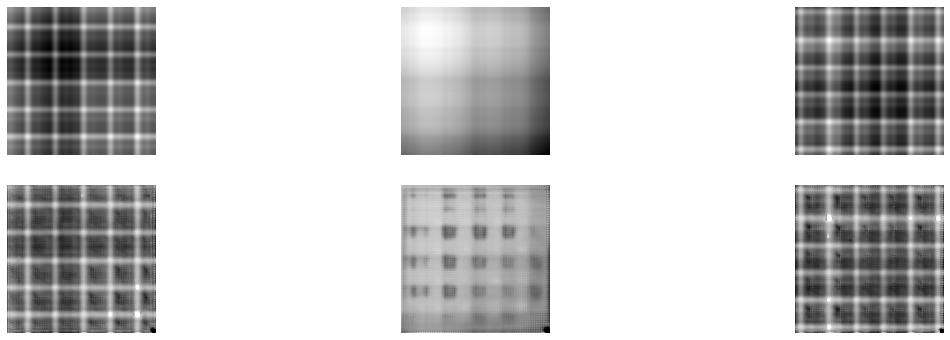

In [ ]:
import matplotlib.pyplot as plt

n_samples = np.shape(X_in)[0]
plt.figure(figsize=(20, 6))
for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i,:,:,0], cmap='gray')
	# plot translated image
for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i,:,:,0], cmap='gray')


In [ ]:
np.shape(X_in)[0]

3

In [ ]:
#for i in range(n_samples):
# imgI = X_in[:,:,:,0]
# imgO = X_out[:,:,:,0]


In [ ]:
### Function to convert a batch of images to a group of singals
def img2signal(Images):
  sigs=[]
  for k in range(np.shape(Images)[0]):
    sig = [Images[k][i,i] for i in range(0, np.shape(Images)[1])]
    sigs.append(sig)
  return np.asarray(sigs)

sigI = img2signal(X_in)
sigO = img2signal(X_out)

In [ ]:
# sigI = [imgI[0][i,i] for i in range(0, 256)]
# sigO = [imgO[0][i,i] for i in range(0, 256)]

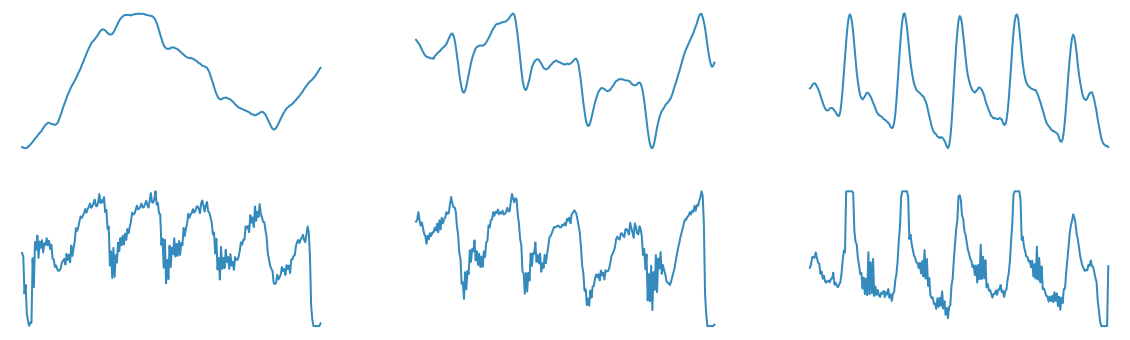

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.figure(figsize=(20, 6))
for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + i)
  plt.axis('off')
  plt.plot(sigI[i])
for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + i + n_samples)
  plt.plot(sigO[i])
  plt.axis('off')


### Check with the model (256,256,3) size

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
image_shape1 = (256,256,3)
g_model_AtoB3channel = define_generator(image_shape1)

In [ ]:
g_model_AtoB3channel = tf.keras.models.load_model('g_model_AtoB_001319.h5')

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
import numpy as np

# load the dataset
#data = load('apple2orange_256.npz')
#dataA, dataB = data['arr_0'], data['arr_1']
#data = load('acc2ppg_256.npz')
data1 = load('acc2ppg_256.npz')
dataA1, dataB1 = data1['arr_0'], data1['arr_1']
print('Loaded: ', dataA1.shape, dataB1.shape)


Loaded:  (2638, 256, 256, 3) (528, 256, 256, 3)


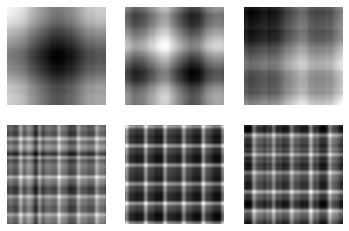

In [ ]:
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA1[i][:,:,0], cmap='gray')	
	#pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB1[i][:,:,0], cmap='gray')
	#pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	print(ix)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# Generate Two Datasets
X_in, _ = generate_real_samples(dataA1, n_samples, 0)
X_out, _ = generate_fake_samples(g_model_AtoB3channel, X_in, 0)
# Scaling from [-1,1]  to [0, 1]
X_in = (X_in + 1) / 2.0
X_out = (X_out + 1) / 2.0

[2238 1576 2352]


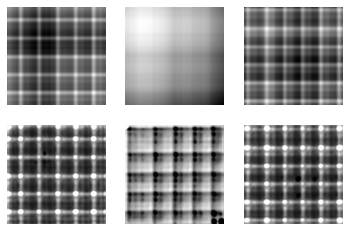

In [ ]:
for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i,:,:,0], cmap='gray')
	# plot translated image
for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i,:,:,0], cmap='gray')

In [ ]:
def img2signal(Images):
  sigs=[]
  for k in range(np.shape(Images)[0]):
    sig = [Images[k][i,i] for i in range(0, np.shape(Images)[1])]
    sigs.append(sig)
  return np.asarray(sigs)

sigI = img2signal(X_in)
sigO = img2signal(X_out)

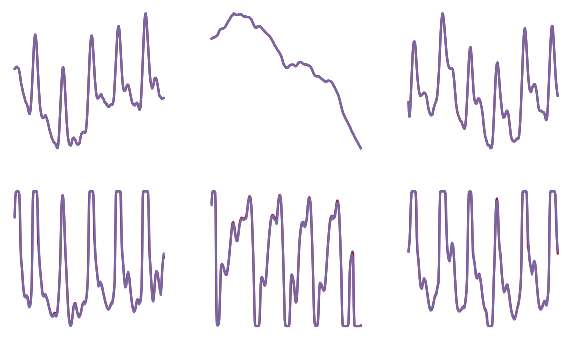

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.figure(figsize=(10, 6))
for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + i)
  plt.axis('off')
  plt.plot(sigI[i])
for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + i + n_samples)
  plt.plot(sigO[i])
  plt.axis('off')

### Save the models

In [ ]:
	save_models(3, g_model_AtoB, g_model_BtoA)

&gt;Saved: g_model_AtoB_000002.h5 and g_model_BtoA_000002.h5


In [ ]:
	save_models1(3, d_model_A, d_model_B)

&gt;Saved: d_model_A_000002.h5 and d_model_B_000002.h5


# Clone from Google

In [ ]:
! git clone https://github.com/pritamqu/ppg2ecg-cardiogan.git

Cloning into 'ppg2ecg-cardiogan'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 70 (delta 26), reused 31 (delta 6), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [ ]:
ls

drive/  ppg2ecg-cardiogan/  sample_data/


In [ ]:
import os
import socket
import time
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
import sklearn.preprocessing as skp
import tflib

import module 
import preprocessing

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

@tf.function
def sample_P2E(P, model):
    fake_ecg = model(P, training=False)
    return fake_ecg




########### params ###########
ecg_sampling_freq = 128
ppg_sampling_freq = 128
window_size = 4
ecg_segment_size = ecg_sampling_freq*window_size
ppg_segment_size = ppg_sampling_freq*window_size
#model_dir = 'path/to/weights'
model_dir = 'weigths/weights'

""" model """
Gen_PPG2ECG = module.generator_attention()
""" resotre """
tflib.Checkpoint(dict(Gen_PPG2ECG=Gen_PPG2ECG), model_dir).restore()
print("model loaded successfully")

""" please process the data as mentioned below before extracting ECG output """
# load the data: x_ppg = np.loadtxt()
# make sure loaded data is a numpy array: x_ppg = np.array(x_ppg)
# resample to 128 Hz using: cv2.resize(x_ppg, (1,ppg_segment_size), interpolation = cv2.INTER_LINEAR)
# filter the data using: preprocessing.filter_ppg(x_ppg, 128)
# make an array to N x 512 [this is the input shape of x_ppg], where Nx512=len(x_ppg)
# normalize the data b/w -1 to 1: x_ppg = skp.minmax_scale(x_ppg, (-1, 1), axis=1)
#######
#x_ecg = sample_P2E(x_ppg, Gen_PPG2ECG)
#######

model loaded successfully


' please process the data as mentioned below before extracting ECG output '

In [ ]:
Gen_PPG2ECG.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf.expand_dims_6 (TFOpLambda)   (None, 1, 512)       0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims_7 (TFOpLambda)   (None, 1, 512, 1)    0           tf.expand_dims_6[0][0]           
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 1, 256, 64)   1024        tf.expand_dims_7[0][0]           
____________________________________________________________________________________________

In [ ]:
%ls

cardiogan_realtime.py  module.py         __pycache__/       tflib.py
layers.py              preprocessing.py  test_cardiogan.py


### Import BioSppy

In [ ]:
 !pip install biosppy

     |████████████████████████████████| 85 kB 4.2 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95430 sha256=d8c66d08766c4c88007f4dac684a449975ca6476e006264ed3f230f749be9590
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [ ]:
cd ppg2ecg-cardiogan/codes

/content/ppg2ecg-cardiogan/codes


In [ ]:
# Notice: using raw address to avoid corrputed
!wget --no-check-certificate --content-disposition https://github.com/pritamqu/ppg2ecg-cardiogan/raw/main/weights/weights.zip

--2021-10-28 04:51:06--  https://github.com/pritamqu/ppg2ecg-cardiogan/raw/main/weights/weights.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pritamqu/ppg2ecg-cardiogan/main/weights/weights.zip [following]
--2021-10-28 04:51:07--  https://media.githubusercontent.com/media/pritamqu/ppg2ecg-cardiogan/main/weights/weights.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216383914 (206M) [application/zip]
Saving to: ‘weights.zip’

weights.zip         100%[===================>] 206.36M   198MB/s    in 1.0s    

2021-10-28 04:51:10 (198 MB/s) - ‘weights.zip’ saved [216383914/2

In [ ]:
ls

cardiogan_realtime.py  module.py         test_cardiogan.py  weights.zip
layers.py              preprocessing.py  tflib.py           weigths/


In [ ]:
!unzip weights.zip -d weigths/

Archive:  weights.zip
   creating: weigths/weights/
  inflating: weigths/weights/checkpoint  
  inflating: weigths/weights/ckpt-1.data-00000-of-00001  
  inflating: weigths/weights/ckpt-1.index  


### neurolkit install

In [ ]:
pip install neurokit2

     |████████████████████████████████| 1.0 MB 21.7 MB/s 


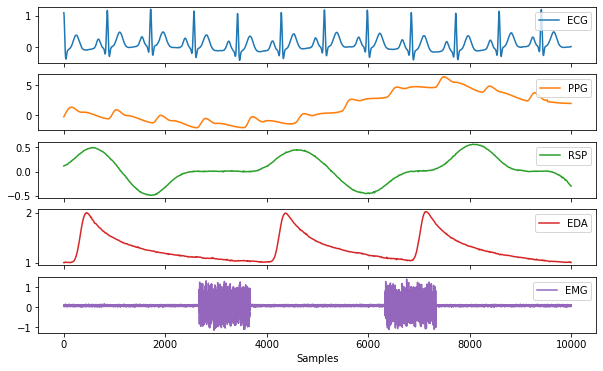

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt


# Generate synthetic signals
ecg = nk.ecg_simulate(duration=10, heart_rate=70)
ppg = nk.ppg_simulate(duration=10, heart_rate=70, motion_amplitude=10)
rsp = nk.rsp_simulate(duration=10, respiratory_rate=15)
eda = nk.eda_simulate(duration=10, scr_number=3)
emg = nk.emg_simulate(duration=10, burst_number=2)

# Visualise biosignals
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg,
                     "RSP": rsp,
                     "EDA": eda,
                     "EMG": emg})

plt.rcParams['figure.figsize'] = [10, 6]  # resize

nk.signal_plot(data, subplots=True)


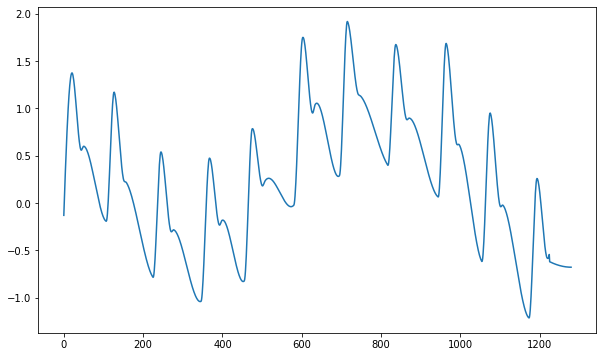

In [ ]:
ppg = nk.ppg_simulate(duration=10, heart_rate=70, motion_amplitude=1, sampling_rate=128)
plt.plot(ppg)

In [ ]:
len(ppg)

1280

In [ ]:
""" please process the data as mentioned below before extracting ECG output """
ECG = []
ppg_tmp = ppg
L = np.ceil(len(ppg)/512)
for i in range(int(L)):
# load the data: 
  
x_ppg = np.zeros(512);
x_ppg = ppg[i*512:(i+1)*512]
#x_ppg = ppg[:512]
# make sure loaded data is a numpy array: 
x_ppg = np.array(x_ppg)
# resample to 128 Hz using: 
cv2.resize(x_ppg, (1,ppg_segment_size), interpolation = cv2.INTER_LINEAR)
x_ppg = x_ppg.reshape(1, -1)
# filter the data using: 
#x_ppg = preprocessing.filter_ppg(x_ppg, 128)
# make an array to N x 512 [this is the input shape of x_ppg], where Nx512=len(x_ppg)
# normalize the data b/w -1 to 1: 
#x_ppg = skp.minmax_scale(x_ppg, (-1, 1), axis=1)
#######
x_ecg = sample_P2E(x_ppg, Gen_PPG2ECG)

x_ecg = x_ecg.numpy()
#x_ecg = preprocessing.filter_ecg(x_ecg, 128)
x_ecg = x_ecg.reshape(-1)


### Plot Fake PPG based cubic interpolations

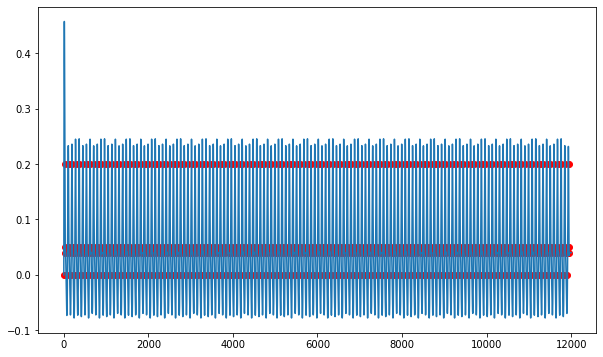

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

sfreq = 100
heartrate = 70    # in bpm
duration = 120    # in seconds

# at the requested sampling rate, how long is a period at the requested heart
# rate and how often does that period fit into the requested duration?
period = 60 / heartrate   # in seconds
n_period = int(np.floor(duration / period))
periods = np.ones(n_period) * period
# seconds at which periods end
x_onset = np.cumsum(periods) - period
y_onset = 0

x_sys = x_onset + 0.3 * period
y_sys = y_onset + .2

x_notch = x_onset + 0.4 * period
y_notch = y_onset + .05

x_dia = x_onset + 0.45 * period
y_dia = y_onset + .04

x_all = np.concatenate((x_onset, x_sys, x_notch, x_dia))
x_all.sort(kind="mergesort")
x_all = np.rint(x_all * sfreq).astype(int)
y_all = [y_onset, y_sys, y_notch, y_dia] * n_period

f = interp1d(x_all, y_all, kind="cubic", bounds_error=False,
              fill_value=([y_all[0]], [y_all[-1]]))
samples = np.arange(0, duration * sfreq)
ppg = f(samples)


#fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

plt.scatter(x_all, y_all, c="r")
plt.plot(ppg)

In [ ]:
x_ppg = np.zeros(512)

In [ ]:
tf.train.Checkpoint()

In [ ]:
for i in range(int(L)):
  print(i)

0
1
2


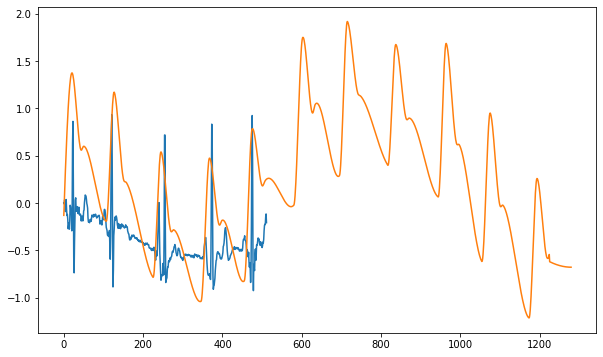

In [ ]:
plt.plot(x_ecg)
plt.plot(ppg)

In [ ]:
model_dir = 'weigths/weights'
Gen_PPG2ECG.load_weights(model_dir)

In [ ]:
ls weigths/weights


checkpoint  ckpt-1.data-00000-of-00001  ckpt-1.index
